Inspired by [Twitter Sentiment Analysis with BERT vs RoBERTa 🐦](https://www.kaggle.com/code/ludovicocuoghi/twitter-sentiment-analysis-with-bert-vs-roberta/notebook), this notebook implements a Twitter sentiment classification task using PyTorch, comparing the performance of BERT and RoBERTa models.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
import string
import emoji
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

# Load data

## Data source

In [2]:
df_train = pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv",
                encoding='ISO-8859-1')
df_test = pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv",
                encoding='ISO-8859-1')

print("Train dataset:",df_train.shape)
print("Train duplicated:",df_train.duplicated().sum())

print("Test dataset:",df_test.shape)
print("Test duplicated:",df_test.duplicated().sum())

print("--- Train columns:")
df_train.info()

Train dataset: (41157, 6)
Train duplicated: 0
Test dataset: (3798, 6)
Test duplicated: 0
--- Train columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


## Convert date dtype

In [3]:
df_train['TweetAt'] = pd.to_datetime(df_train['TweetAt'])
df_test['TweetAt'] = pd.to_datetime(df_test['TweetAt'], format='%d-%m-%Y')

df_train['set'] = 'train'
df_test['set'] = 'test'

df = pd.concat([df_train, df_test])
print(df.shape)
print(df.dtypes)
df.head()

(44955, 7)
UserName                  int64
ScreenName                int64
Location                 object
TweetAt          datetime64[ns]
OriginalTweet            object
Sentiment                object
set                      object
dtype: object


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,set
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,train
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,train
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,train
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive,train
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative,train


# EDA

## Tweet counts per Day by set

In [4]:
df['TweetMonthDay'] = df['TweetAt'].dt.strftime('%m-%d')

tweets_per_day = df.groupby(['set', 'TweetMonthDay']).size().reset_index(name='counts')
tweets_per_day.head()

,set,TweetMonthDay,counts
0,test,03-02,4
1,test,03-03,4
2,test,03-04,8
3,test,03-05,6
4,test,03-06,2


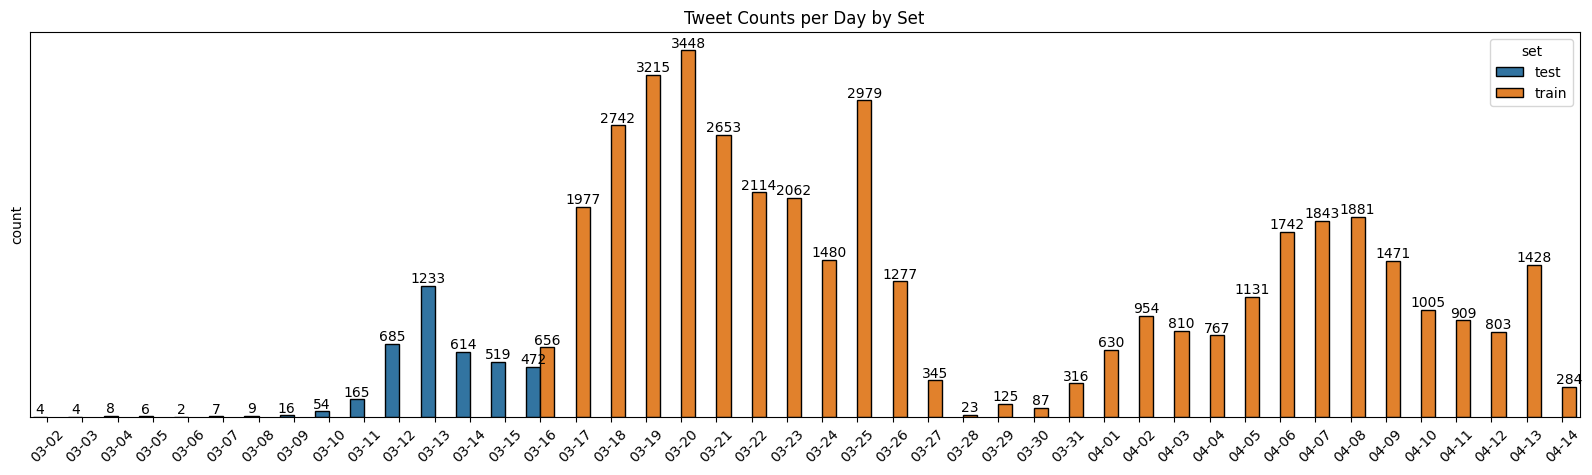

In [5]:
plt.figure(figsize=(20,5))
ax = sns.barplot(x='TweetMonthDay', 
                 y='counts', 
                 hue='set',
                 data=tweets_per_day,
                 edgecolor = 'black',
                )
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(rotation=45)
plt.yticks([])
plt.xlabel('')
plt.ylabel('count')
plt.title('Tweet Counts per Day by Set')
# plt.tight_layout()
plt.show()

# Pre-processing

## Clean tweet texts

In [6]:
def process_tweet(text):
    # remove multiple spaces
    text = re.sub("\s\s+" , " ", text)
    
    #Clean emojis from text
    # text = re.sub(emoji.get_emoji_regexp(), r"", text)
    emojis = [re.escape(e["emoji"]) for e in emoji.emoji_list(text)]
    pattern = re.compile("|".join(emojis))
    text = pattern.sub("", text)

    #Remove punctuations, links, mentions and \r\n new line characters
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)

    # clean hashtags at the end of the sentence, 
    # and keep those in the middle of the sentence by removing just the # symbol
    text = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text)) #remove last hashtags
    text = " ".join(word.strip() for word in re.split('#|_', text)) #remove hashtags symbol from words in the middle of the sentence

    # remove any word that contains either a dollar sign ($) or an ampersand (&)
    
    return text


df['cleaned_text'] = df['OriginalTweet'].apply(process_tweet)

In [7]:
# remove tweets with less than 5 cleaned words
df['text_len'] = df['cleaned_text'].apply(lambda x: len(x.split()))
df = df[df['text_len'] > 4]
df.shape

(44727, 10)

In [8]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,set,TweetMonthDay,cleaned_text,text_len
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,train,03-16,advice talk to your neighbours family to excha...,38
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,train,03-16,coronavirus australia woolworths to give elder...,13
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive,train,03-16,my food stock is not the only one which is emp...,41
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative,train,03-16,me ready to go at supermarket during the covid...,39
5,3804,48756,"ÃT: 36.319708,-82.363649",2020-03-16,As news of the regionÂs first confirmed COVID...,Positive,train,03-16,as news of the regions first confirmed covid19...,34


## Clean sentiment labels

In [9]:
senti_label = {
    'Neutral': 'neutral', 
    'Positive': 'positive', 
    'Extremely Positive': 'positive',
    'Extremely Negative': 'negative', 
    'Negative': 'negative'
}

df['label'] = df['Sentiment'].map(senti_label)

### Label encoder

In [10]:
id2label = {0: "negative", 1: "neutral", 2: "positive"}
label2id = {"negative": 0, "neutral": 1, "positive": 2}

In [11]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['label_sk'] = label_encoder.fit_transform(df['label'])

label_list = list(label_encoder.classes_)
print(len(label_list))
label_list

3


['negative', 'neutral', 'positive']

# LLM Classifier

## Configuration

In [12]:
class CFG:
    max_seq_len = 64
    batch_size = 64
    epochs = 5
    learning_rate = 5e-5

## General functions

### Prepare dataset

In [13]:
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer


class TweetDataset(Dataset):
    def __init__(self, df, tokenizer_path, labeled=True, 
                 text_column='cleaned_text', label_column='label_sk'):
        self.df = df
        self.labeled = labeled
        self.text_column = text_column
        self.label_column = label_column
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        sentence = row[self.text_column]

        # Tokenize the single sentence
        encoded = self.tokenizer(
            sentence,
            padding='max_length',
            truncation=True,
            max_length=CFG.max_seq_len,
            return_tensors='pt'
        )

        # Remove batch dimension from tokenizer output
        input_ids = encoded['input_ids'].squeeze(0)
        attention_mask = encoded['attention_mask'].squeeze(0)

        if self.labeled:
            label = torch.tensor(int(row[self.label_column]))
            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'labels': label
            }
        else:
            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask
            }

    def collate_fn(self, batch):
        input_ids = torch.stack([item['input_ids'] for item in batch])
        attention_mask = torch.stack([item['attention_mask'] for item in batch])

        if self.labeled:
            labels = torch.stack([item['labels'] for item in batch])
            return input_ids, attention_mask, labels
        else:
            return input_ids, attention_mask

### Train one epoch

In [14]:
from datetime import datetime


def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    start_time = datetime.now()
    
    all_losses = []
    all_labels = []
    all_preds = []

    for batch in tqdm(dataloader, desc="Training", leave=False):
        # Move data to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Zero out gradients from previous step
        optimizer.zero_grad()

        # Forward pass
        loss, predictions = model(input_ids, attention_mask, labels, training=True)

        # Backward pass and optimizer step
        loss.backward()
        optimizer.step()
        # scheduler.step()

        # Record loss and predictions
        all_losses.append(loss.item())
        all_labels.append(labels.cpu().numpy())
        probs = predictions[:, 1].detach().cpu().numpy()  # class 1 probability
        all_preds.append(probs)

    # Calculate average loss and AUC score
    avg_loss = sum(all_losses) / len(all_losses)    
    elapsed_time = datetime.now() - start_time
    return avg_loss, elapsed_time

### Evaluation

In [15]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score

def evaluate(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass (no loss needed)
            logits = model(input_ids, attention_mask, training=False)
            probs = torch.softmax(logits, dim=-1)
            preds = torch.argmax(logits, dim=-1)  # Get the predicted class (0 or 1)

            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    # Convert lists to numpy arrays
    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    all_probs = np.concatenate(all_probs)

    # Compute accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    # Compute micro-precision, micro-recall, micro-f1
    micro_precision = precision_score(all_labels, all_preds, average='micro')
    micro_recall = recall_score(all_labels, all_preds, average='micro')
    micro_f1 = f1_score(all_labels, all_preds, average='micro')

    # Compute auc
    roc_auc = roc_auc_score(all_labels, all_probs, average='micro', multi_class='ovr')

    # Return the evaluation metrics
    return accuracy, micro_f1, roc_auc

### Prediction

In [16]:
def predict_new_data(model, tokenizer, texts, device):

    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=64,
        return_tensors="pt"
    )

    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask, training=False)
        predictions = torch.argmax(logits, dim=-1).cpu().numpy()

    return predictions

## BERT

In [17]:
pretrain_model_path = "google-bert/bert-base-uncased"

### Prepare dataset

In [18]:
from torch.utils.data import DataLoader

df_train = df[df['set']=='train']
df_test = df[df['set']=='test']
print(df_train.shape, df_test.shape)

train_dataset = TweetDataset(df_train, tokenizer_path=pretrain_model_path, labeled=True, label_column='label_sk')
test_dataset = TweetDataset(df_test, tokenizer_path=pretrain_model_path, labeled=True, label_column='label_sk')

train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False)

(40935, 12) (3792, 12)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [19]:
# test

ds = TweetDataset(df.iloc[3], tokenizer_path=pretrain_model_path,labeled=True, label_column='label_sk')
ds.df

UserName                                                      3803
ScreenName                                                   48755
Location                                                       NaN
TweetAt                                        2020-03-16 00:00:00
OriginalTweet    Me, ready to go at supermarket during the #COV...
Sentiment                                       Extremely Negative
set                                                          train
TweetMonthDay                                                03-16
cleaned_text     me ready to go at supermarket during the covid...
text_len                                                        39
label                                                     negative
label_sk                                                         0
Name: 4, dtype: object

### Model

In [20]:
import torch.nn as nn
from transformers import BertModel


class BertClassifier(nn.Module):
    def __init__(self, pretrain_model_path='bert-base-uncased', 
                 num_classes=3, hidden_size=768):
        super(BertClassifier, self).__init__()
        
        # bert model
        self.bert = BertModel.from_pretrained(pretrain_model_path)

        # enable fine-tuning
        for param in self.bert.parameters():
            param.requires_grad = True

        # dropout layer
        self.dropout = nn.Dropout(p=0.1)

        # transfrom from bert logits to classfier classes
        self.classifier = nn.Linear(hidden_size, num_classes)

        self.num_classes = num_classes

    def forward(self, input_ids, attention_mask, labels=None, training=True):
        # loss function
        loss_fn = nn.CrossEntropyLoss()

        # BERT outputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.pooler_output  # CLS vector

        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)

        if training and labels is not None:
            # if training, calculate loss and return prediction prob
            loss = loss_fn(logits, labels)
            probs = nn.Softmax(dim=-1)(logits)
            return loss, probs
        else:
            # if eval, return logits only
            return logits

    def save_pretrained(self, save_directory):
        os.makedirs(save_directory, exist_ok=True)
        torch.save(self.state_dict(), os.path.join(save_directory, "pytorch_model.bin"))
        if hasattr(self, 'config') and self.config is not None:
            self.config.save_pretrained(save_directory)

2025-05-08 05:23:51.885680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746681831.908410     147 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746681831.915303     147 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Fine-tuning

In [21]:
from torch.optim import AdamW

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained(pretrain_model_path)
bertmodel = BertClassifier(pretrain_model_path=pretrain_model_path, num_classes=len(label_list))

bertmodel.to(device)
bertmodel.train()

optimizer = AdamW(bertmodel.parameters(), lr=CFG.learning_rate)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [22]:
for param_group in optimizer.param_groups:
    print(param_group['lr'])

5e-05


In [23]:
# traing the model
for epoch in range(CFG.epochs):
    print(f"\n🚀 Epoch {epoch + 1}")

    # Get current learning rate
    # current_lr = scheduler.get_lr()[0] 
    current_lr = optimizer.param_groups[0]['lr']

    train_loss, train_time = train_one_epoch(bertmodel, train_loader, optimizer, device)
    print(f"Train Loss: {train_loss:.4f} | LR: {current_lr:.8f} | Time: {train_time}")

    accuracy, micro_f1, roc_auc = evaluate(bertmodel, test_loader, device)
    print(f"✅ Validation: Accuracy:{accuracy:.3f}, F1-score:{micro_f1:.3f}, AUC:{roc_auc:.2f}")


🚀 Epoch 1


Train Loss: 0.4581 | LR: 0.00005000 | Time: 0:04:03.147308


✅ Validation: Accuracy:0.889, F1-score:0.889, AUC:0.97

🚀 Epoch 2


Train Loss: 0.2295 | LR: 0.00005000 | Time: 0:04:03.447420


✅ Validation: Accuracy:0.903, F1-score:0.903, AUC:0.98

🚀 Epoch 3


Train Loss: 0.1612 | LR: 0.00005000 | Time: 0:04:03.581257


✅ Validation: Accuracy:0.899, F1-score:0.899, AUC:0.97

🚀 Epoch 4


Train Loss: 0.1239 | LR: 0.00005000 | Time: 0:04:03.957196


✅ Validation: Accuracy:0.905, F1-score:0.905, AUC:0.98

🚀 Epoch 5


Train Loss: 0.0891 | LR: 0.00005000 | Time: 0:04:03.652336


✅ Validation: Accuracy:0.897, F1-score:0.897, AUC:0.97


### Prediction

In [24]:
test_texts = df_test['cleaned_text'].to_list()
y_test = df_test['label_sk'].to_list()

y_pred_bert = predict_new_data(bertmodel, tokenizer, test_texts, device)
y_label_class = label_encoder.classes_[y_pred_bert]

from sklearn.metrics import classification_report

print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.90      0.92      0.91      1632
     Neutral       0.88      0.79      0.83       615
    Positive       0.90      0.92      0.91      1545

    accuracy                           0.90      3792
   macro avg       0.89      0.88      0.88      3792
weighted avg       0.90      0.90      0.90      3792



### EDA - Confusion matrix

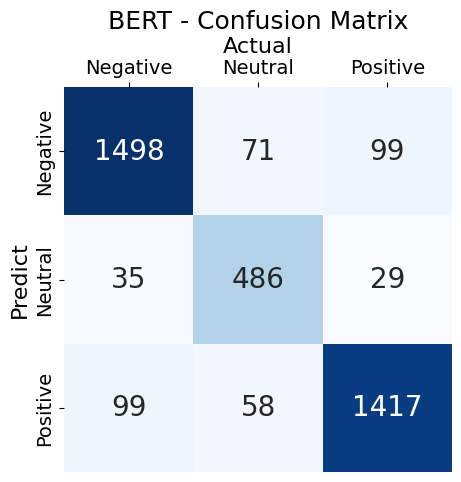

In [25]:
from sklearn.metrics import confusion_matrix

def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y_pred, y), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":20})
    plt.title(title, fontsize=18)
    ax.xaxis.set_ticklabels(labels, fontsize=14) 
    ax.yaxis.set_ticklabels(labels, fontsize=14)
    ax.set_ylabel('Predict', fontsize=16)
    ax.set_xlabel('Actual', fontsize=16)
    ax.xaxis.set_label_position('top')  # Move x-axis label
    ax.xaxis.tick_top()                 # Move x-axis ticks to top
    plt.show()

conf_matrix(y_test, y_pred_bert, 'BERT - Confusion Matrix')

### EDA - tokens

In [26]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

df['tokens'] = df['cleaned_text'].apply(lambda x: tokenizer(x)['input_ids'])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token len median: 40.0


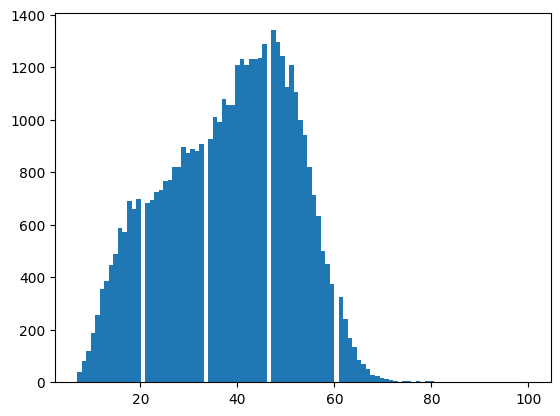

In [27]:
df['token_length'] = df['tokens'].apply(len)
print('Token len median:', df['token_length'].median())

plt.hist(df['token_length'], bins = 100);

In [28]:
# Further: filter blank texts
df[['cleaned_text', 'token_length', 'label']].sort_values('token_length').head()

,cleaned_text,token_length,label
28806,have you checked this out,7,neutral
28604,you can only keep three,7,neutral
20543,be safe and stay home,7,positive
7844,the heroes of our times,7,positive
9323,19 anybody happy right now,7,positive


In [29]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,set,TweetMonthDay,cleaned_text,text_len,label,label_sk,tokens,token_length
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,train,03-16,advice talk to your neighbours family to excha...,38,positive,2,"[101, 6040, 2831, 2000, 2115, 14754, 2155, 200...",42
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,train,03-16,coronavirus australia woolworths to give elder...,13,positive,2,"[101, 21887, 23350, 2660, 12121, 5172, 2015, 2...",20
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive,train,03-16,my food stock is not the only one which is emp...,41,positive,2,"[101, 2026, 2833, 4518, 2003, 2025, 1996, 2069...",57
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative,train,03-16,me ready to go at supermarket during the covid...,39,negative,0,"[101, 2033, 3201, 2000, 2175, 2012, 17006, 207...",56
5,3804,48756,"ÃT: 36.319708,-82.363649",2020-03-16,As news of the regionÂs first confirmed COVID...,Positive,train,03-16,as news of the regions first confirmed covid19...,34,positive,2,"[101, 2004, 2739, 1997, 1996, 4655, 2034, 4484...",41


## RoBERTa

In [30]:
pretrain_model_path = "FacebookAI/roberta-base"

### Prepare dataset

In [31]:
from torch.utils.data import DataLoader

df_train = df[df['set']=='train']
df_test = df[df['set']=='test']
print(df_train.shape, df_test.shape)

train_dataset = TweetDataset(df_train, tokenizer_path=pretrain_model_path, labeled=True, label_column='label_sk')
test_dataset = TweetDataset(df_test, tokenizer_path=pretrain_model_path, labeled=True, label_column='label_sk')

train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False)

(40935, 14) (3792, 14)


### Model

In [32]:
import torch.nn as nn
from transformers import RobertaModel


class RobertaClassifier(nn.Module):
    def __init__(self, pretrain_model_path='roberta-base', 
                 num_classes=3, hidden_size=768):
        super(RobertaClassifier, self).__init__()
        
        # bert model
        self.roberta = RobertaModel.from_pretrained(pretrain_model_path)

        # enable fine-tuning
        for param in self.roberta.parameters():
            param.requires_grad = True

        # dropout layer
        self.dropout = nn.Dropout(p=0.1)

        # transfrom from bert logits to classfier classes
        self.classifier = nn.Linear(hidden_size, num_classes)

        self.num_classes = num_classes

    def forward(self, input_ids, attention_mask, labels=None, training=True):
        # loss function
        loss_fn = nn.CrossEntropyLoss()

        # RoBERTa outputs
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0]  # Use <s> token (equiv. to [CLS])

        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)

        if training and labels is not None:
            # if training, calculate loss and return prediction prob
            loss = loss_fn(logits, labels)
            probs = nn.Softmax(dim=-1)(logits)
            return loss, probs
        else:
            # if eval, return logits only
            return logits

    def save_pretrained(self, save_directory):
        os.makedirs(save_directory, exist_ok=True)
        torch.save(self.state_dict(), os.path.join(save_directory, "pytorch_model.bin"))
        if hasattr(self, 'config') and self.config is not None:
            self.config.save_pretrained(save_directory)

### Fine-tuning

In [33]:
from torch.optim import AdamW

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained(pretrain_model_path)
robertamodel = RobertaClassifier(pretrain_model_path=pretrain_model_path, num_classes=len(label_list))

robertamodel.to(device)
robertamodel.train()

optimizer = AdamW(robertamodel.parameters(), lr=CFG.learning_rate)

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
# traing the model
for epoch in range(CFG.epochs):
    print(f"\n🚀 Epoch {epoch + 1}")

    # Get current learning rate
    # current_lr = scheduler.get_lr()[0] 
    current_lr = optimizer.param_groups[0]['lr']

    train_loss, train_time = train_one_epoch(robertamodel, train_loader, optimizer, device)
    print(f"Train Loss: {train_loss:.4f} | LR: {current_lr:.8f} | Time: {train_time}")

    accuracy, micro_f1, roc_auc = evaluate(robertamodel, test_loader, device)
    print(f"✅ Validation: Accuracy:{accuracy:.3f}, F1-score:{micro_f1:.3f}, AUC:{roc_auc:.2f}")


🚀 Epoch 1


Train Loss: 0.5126 | LR: 0.00005000 | Time: 0:04:05.932794


✅ Validation: Accuracy:0.872, F1-score:0.872, AUC:0.96

🚀 Epoch 2


Train Loss: 0.2974 | LR: 0.00005000 | Time: 0:04:05.688369


✅ Validation: Accuracy:0.891, F1-score:0.891, AUC:0.97

🚀 Epoch 3


Train Loss: 0.2245 | LR: 0.00005000 | Time: 0:04:05.251278


✅ Validation: Accuracy:0.893, F1-score:0.893, AUC:0.97

🚀 Epoch 4


Train Loss: 0.1797 | LR: 0.00005000 | Time: 0:04:05.048166


✅ Validation: Accuracy:0.899, F1-score:0.899, AUC:0.97

🚀 Epoch 5


Train Loss: 0.1491 | LR: 0.00005000 | Time: 0:04:05.073987


✅ Validation: Accuracy:0.896, F1-score:0.896, AUC:0.97


### Prediction

In [35]:
test_texts = df_test['cleaned_text'].to_list()
y_test = df_test['label_sk'].to_list()

y_pred_roberta = predict_new_data(robertamodel, tokenizer, test_texts, device)
y_label_class = label_encoder.classes_[y_pred_roberta]

from sklearn.metrics import classification_report
print('\tClassification Report for RoBERTa:\n\n',classification_report(y_test,y_pred_roberta, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for RoBERTa:

               precision    recall  f1-score   support

    Negative       0.90      0.92      0.91      1632
     Neutral       0.83      0.80      0.82       615
    Positive       0.92      0.91      0.91      1545

    accuracy                           0.90      3792
   macro avg       0.88      0.88      0.88      3792
weighted avg       0.90      0.90      0.90      3792



## Results

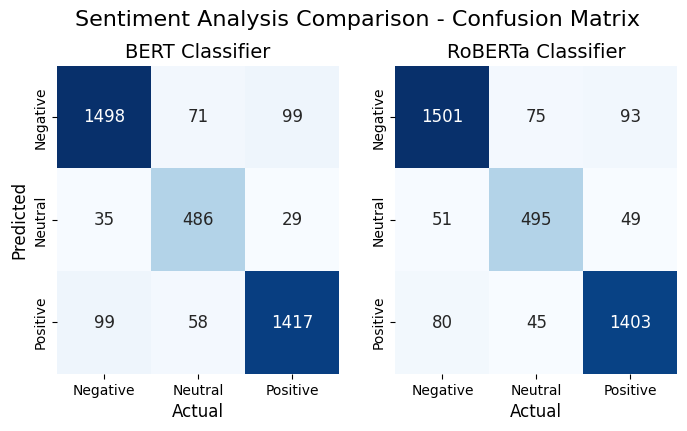

In [36]:
fig, ax = plt.subplots(1,2,figsize=(8,4))

labels = ['Negative', 'Neutral', 'Positive']
plt.suptitle('Sentiment Analysis Comparison - Confusion Matrix', fontsize=16, y=1.02)


sns.heatmap(confusion_matrix(y_pred_bert, y_test), annot=True, cmap="Blues", 
            fmt='g', cbar=False, ax=ax[0], annot_kws={"size":12})
ax[0].set_title('BERT Classifier', fontsize=14)
ax[0].set_yticklabels(labels, fontsize=10);
ax[0].set_xticklabels(labels, fontsize=10);
ax[0].set_ylabel('Predicted', fontsize=12)
ax[0].set_xlabel('Actual', fontsize=12)

sns.heatmap(confusion_matrix(y_pred_roberta, y_test), annot=True, cmap="Blues", 
            fmt='g', cbar=False, ax=ax[1], annot_kws={"size":12})
ax[1].set_title('RoBERTa Classifier', fontsize=14)
ax[1].set_yticklabels(labels, fontsize=10);
ax[1].set_xticklabels(labels, fontsize=10);
# ax[1].set_ylabel('Test', fontsize=12)
ax[1].set_xlabel('Actual', fontsize=12)

plt.show()